In [1]:
%load_ext autoreload
%autoreload 2
import dotenv
dotenv.load_dotenv()

True

# Load experiment
Model is expected to be trained with the `deepsport` repository: https://github.com/gabriel-vanzandycke/deepsport

In [2]:
import os
from experimentator import build_experiment

experiment_id = 'latest'   # update with experiment ID
folder = os.path.join(os.environ['RESULTS_FOLDER'], "ballsize", experiment_id)
exp = build_experiment(os.path.join(folder, 'config.py'))

ball_views.pickle found in /home/gva/repositories/deepsport/basketball-instants-dataset/ball_views.pickle
loading '/home/gva/repositories/deepsport/results/ballsize/latest/0100_weights'


# Visualize metrics

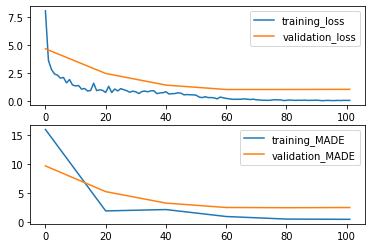

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from experimentator import DataCollector

dc = DataCollector(os.path.join(folder, "history.dcp"))
fig, axes = plt.subplots(2,1)
for ax, metric in zip(axes, ["loss", "MADE"]):
    for subset in ["training", "validation"]:
        label = f"{subset}_{metric}"
        l = np.array(dc[label, :])
        w = np.where(l)[0]
        ax.plot(w, l[w], label=label)
    ax.legend()

# Illustrate inference result

Initializing model with {'batch_input_image': TensorSpec(shape=(6, 64, 64, 3), dtype=tf.uint8, name=None), 'batch_ball_size': TensorSpec(shape=(6,), dtype=tf.float64, name=None)}
Initializing 'tf.keras.applications.vgg16.VGG16' with input KerasTensor(type_spec=TensorSpec(shape=(6, 64, 64, 3), dtype=tf.float32, name=None), name='tf.math.truediv/truediv:0', description="created by layer 'tf.math.truediv'")


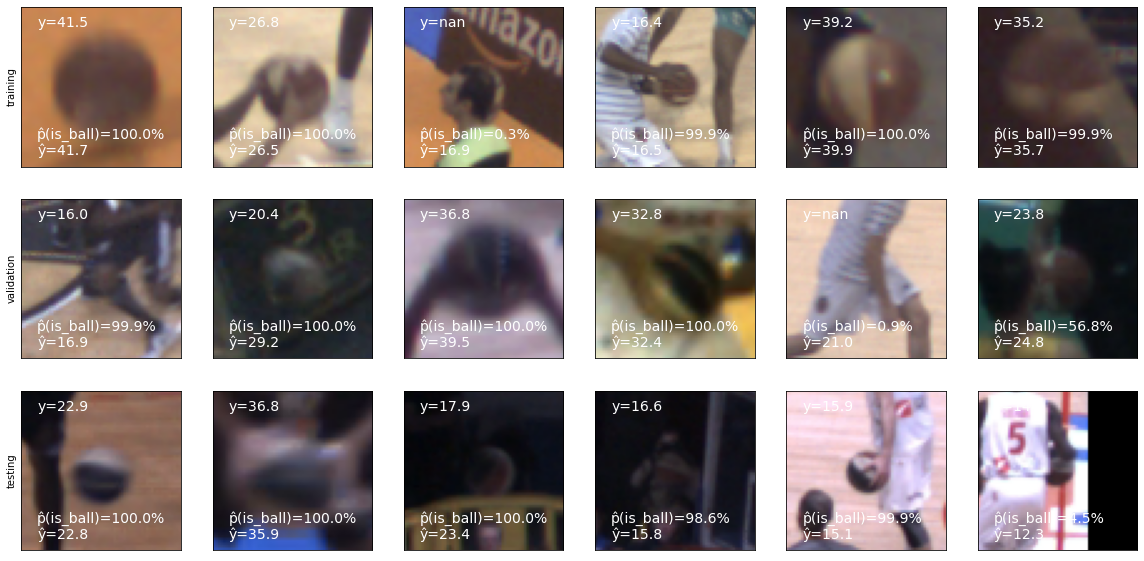

In [4]:
from matplotlib import pyplot as plt
from experimentator.dataset import collate_fn

N = 6
fig, axes = plt.subplots(len(exp.subsets), N, figsize=(20,10))
for i, subset in enumerate(exp.subsets):
    keys = subset.keys
    batch_input = subset.dataset.query(keys[0:N], collate_fn=collate_fn)
    batch_output = exp.batch_eval(batch_input)
    for j in range(N):
        ax = axes[i,j]
        ax.imshow(batch_input["batch_input_image"][j])
        ax.set_xticks([])
        ax.set_yticks([])
        for y, text in [
            (.9, f"y={batch_input['batch_ball_size'][j]:.1f}"),
            (.2, f"p̂(is_ball)={batch_output['predicted_is_ball'][j]*100:.1f}%"),
            (.1, f"ŷ={batch_output['predicted_diameter'][j]:.1f}"),
        ]:
            ax.text(.1, y, text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, color='white', fontsize=14)
    axes[i,0].set_ylabel(subset.name)

# Generate testing submission file
### Load testing set

In [5]:
from mlworkflow import PickledDataset, TransformedDataset
from experimentator import find, collate_fn
from tools.utils import PredictionsDumper, CropCenterTransform

ds = PickledDataset(find("ball_dataset_test.pickle"))
ds = TransformedDataset(ds, [CropCenterTransform(exp.cfg["side_length"])])

ball_dataset_test.pickle found in /home/gva/repositories/deepsport/basketball-instants-dataset/ball_dataset_test.pickle


### Run inference

In [6]:
with PredictionsDumper("testing_set_predictions.json") as pd:
    for keys, data in ds.batches(batch_size=N, collate_fn=collate_fn):
        output = exp.predict(data) # Generates a warning that should be ignored
        for key, prediction in zip(keys, output['predicted_diameter']):
            pd(key, float(prediction))


Two checkpoint references resolved to different objects (<keras.engine.functional.Functional object at 0x7f621848e910> and <keras.engine.sequential.Sequential object at 0x7f62183a7850>).

Two checkpoint references resolved to different objects (<keras.engine.sequential.Sequential object at 0x7f62183a7850> and <keras.layers.core.SlicingOpLambda object at 0x7f6218351760>).


testing_set_predictions.json successfully written


# Generate challenge submission file
### Load challenge set

In [7]:
from mlworkflow import PickledDataset, TransformedDataset
from experimentator import find, collate_fn
from tools.utils import PredictionsDumper, CropCenterTransform

ds = PickledDataset(find("ball_dataset_challenge.pickle"))
ds = TransformedDataset(ds, [CropCenterTransform(exp.cfg["side_length"])])

ball_dataset_challenge.pickle found in /home/gva/repositories/deepsport/basketball-instants-dataset/ball_dataset_challenge.pickle


### Predict on challenge set batches

In [8]:
it = ds.batches(batch_size=N, collate_fn=collate_fn)

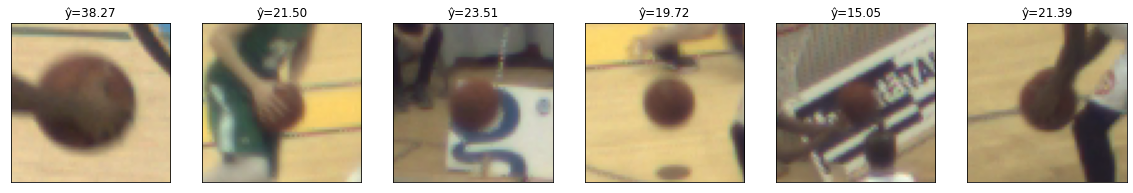

In [9]:
keys, data = next(it)
output = exp.predict(data)
fig, axes = plt.subplots(1, len(keys), figsize=(20,20))
for i, (ax, key) in enumerate(zip(axes, keys)):
    ax.imshow(data["batch_input_image"][i])
    ax.set_title("ŷ={:.2f}".format(output["predicted_diameter"][i]))
    ax.set_xticks([])
    ax.set_yticks([])
    

### Run inference

In [10]:
with PredictionsDumper("challenge_set_predictions.json") as pd:
    for keys, data in ds.batches(batch_size=N, collate_fn=collate_fn):
        output = exp.predict(data)
        for key, prediction in zip(keys, output['predicted_diameter']):
            pd(key, float(prediction))

challenge_set_predictions.json successfully written
